In [166]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
import astropy
import astropy.units as u
import corner
from astropy.cosmology import Flatw0waCDM

In [189]:
# Astropy.cosmology version.Here I am using FlatwowaCDM because it has less parameters.(no Ode)
def Hz1(z1,H01,Om1,w01,wa1):
    cosmo =Flatw0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,w0=w01,wa=wa1) 
    #the redshift dependence of the dark energy density:
    I = cosmo.de_density_scale(z1)
    E = np.sqrt((Om1*(1+z1)**3.) + (1.-Om1)*I)
    HZ1 = H01*E
    return HZ1

In [190]:
#Define  random redshifts
num_zs = 1000
zs= np.linspace(0.01, 5., num=num_zs)

In [191]:
#O_m= 0.291
#w_0= -0.961
#w_1= -0.28
#H_0= 74

In [192]:
#From Planck observations for CPL mode
O_m= 0.291
w_0= -0.9
w_1= 0.28
H_0= 74.

In [193]:
#Hubble comoving parameter
Hz=Hz1(zs,H_0,O_m,w_0,w_1)/(1+zs)

In [194]:
#random error for Hz
error_sigma = 0.5
e1 = np.random.normal(0., error_sigma, Hz.shape)

In [195]:
H_zz= Hz + e1

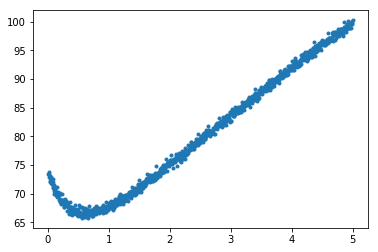

In [196]:
plt.plot(zs,H_zz, '.')

In [197]:
p = lmfit.Parameters()
p.add_many(('Om1',0.3,True,0.,2.),
           ('H01',70.,True,50.,100.),
           ('w01',-1.0,True,-2.,2.),
           ('wa1',-0.1,True,-1.,1.))

def residual(p):
    v = p.valuesdict()
    return (Hz1(zs,v['H01'],v['Om1'],v['w01'],v['wa1'])/(1+zs)-H_zz)/error_sigma

In [198]:
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 1000
    # variables        = 4
    chi-square         = 935.662474
    reduced chi-square = 0.93942015
    Akaike info crit   = -58.5004718
    Bayesian info crit = -38.8694507
[[Variables]]
    Om1:  0.29126891 +/- 0.00152868 (0.52%) (init = 0.3)
    H01:  73.9357203 +/- 0.12431251 (0.17%) (init = 70)
    w01: -0.89657768 +/- 0.00862590 (0.96%) (init = -1)
    wa1:  0.27753563 +/- 0.02948690 (10.62%) (init = -0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(w01, wa1) = -0.935
    C(Om1, wa1) = -0.929
    C(Om1, w01) =  0.923
    C(Om1, H01) = -0.895
    C(H01, w01) = -0.869
    C(H01, wa1) =  0.724


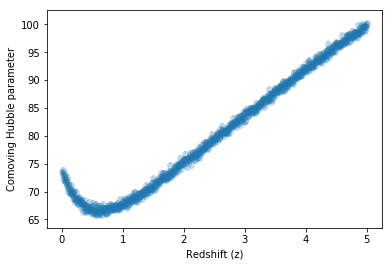

In [199]:
plt.errorbar(zs,H_zz,yerr=error_sigma,fmt='o',alpha=0.2)
bestOm1 = mi.params.valuesdict()['Om1']
bestH01 = mi.params.valuesdict()['H01']
bestw01 = mi.params.valuesdict()['w01']
bestwa1 = mi.params.valuesdict()['wa1']
plt.plot(zs,Hz1(zs,bestH01,bestOm1,bestw01,bestwa1)/(1+zs))
plt.plot(zs,Hz)
plt.xlabel('Redshift (z)')
plt.ylabel('Comoving Hubble parameter')
lmfit.report_fit(mi)

In [165]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500,thin=1,
                         params=p, is_weighted=True)

emcee: Exception while calling your likelihood function:
  params: [ 0.30162869 69.98715626 -1.00062306 -0.10005794]
  args: (<function residual at 0x7f9ae59910c8>, Parameters([('Om1', <Parameter 'Om1', 0.30162868756715744, bounds=[0.0:2.0]>), ('H01', <Parameter 'H01', 69.9871562561178, bounds=[50.0:100.0]>), ('w01', <Parameter 'w01', -1.0006230642078042, bounds=[-2.0:2.0]>), ('wa1', <Parameter 'wa1', -0.10005794365181325, bounds=[-1.0:1.0]>)]), ['Om1', 'H01', 'w01', 'wa1'], array([[  0.,   2.],
       [ 50., 100.],
       [ -2.,   2.],
       [ -1.,   1.]]))
  kwargs: {'nan_policy': 'omit', 'userkws': {}, 'userargs': [], 'is_weighted': True, 'float_behavior': 'posterior'}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/alexandra/.local/lib/python2.7/site-packages/lmfit/minimizer.py", line 2015, in _lnpost
    out = userfcn(params, *userargs, **userkwargs)
  File "<ipython-input-162-dde723dcd5ae>", line 9, in residual
    return (Hz1(zs,v['H01'],v['Om1'],v['w01'],v['wa1'])/(1+zs)-H_zz)/error_sigma
  File "<ipython-input-154-e69a33b13a38>", line 6, in Hz1
    E = np.sqrt((Om1*(1+z1)**3.) + (1.-Om1)*I)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
corner.corner(res.flatchain,labels=res.var_names, truths=list(res.params.valuesdict().values()))

In [ ]:
# plt.plot(res.flatchain.H01)
plt.plot(res.flatchain.wa1)